# **0. Getting started with this notebook**
---
This notebook contains two types of cell: text and code.

*   **Text** cells are formatted using a simple markup language called Markdown. They can be create by clickin in  ``` + text ``` 
*   **Code** cells contain either explanatory text or executable code and its output. They can be create by clickin in  ``` + code ```  

For more information about these type of cells you can click [here](https://colab.research.google.com/notebooks/basic_features_overview.ipynb). 

# **1. Getting Set Up**
---

> ## **1.2. Importing packages**

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
import segmentation_models as sm
import albumentations as A
from sklearn.model_selection import train_test_split
import tifffile

# Check versions
print("Tensorflow", tf.__version__)
print("Albumentations", A.__version__)
print("segmentation-models", sm.__version__)

sm.set_framework('tf.keras')
sm.framework()

Segmentation Models: using `keras` framework.
Tensorflow 2.8.0
Albumentations 1.1.0
segmentation-models 1.0.1


'tf.keras'

# **2. Complete the Colab session**
---




> ## **2.2. Check for GPU access**



First, you'll need to enable GPUs for the notebook:

- Navigate to Edit→Notebook Settings
- select GPU from the Hardware Accelerator drop-down

Next, we'll confirm that we can connect to the GPU with tensorflow:
For more information click [here](https://cloud.google.com/gpu)

In [3]:
# Choose tensorflow version
#%tensorflow_version 2.x

#@markdown # Make sure the GPU is available
# Make sure the GPU is available
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


# **3. Input and pre-processing**
---

In [13]:
# ------------- Initial user input ------------
#@markdown ###Path to training images:
images_dir = "C:/Users/utraf/Documents/Nathaly/Cerebellum Team/Malala/Nuclei/Images ordered" #@param {type:"string"}
masks_dir = "C:/Users/utraf/Documents/Nathaly/Cerebellum Team/Malala/Nuclei/Mask Binary"#@param {type:"string"}

# -------------  Split training images into train, testing and validation filelists ------------
images_filelist = sorted(os.listdir(images_dir))
masks_filelist = sorted(os.listdir(masks_dir))

#@markdown ###Splitting in training, testing and validating data:
#@markdown A set of training images along with masks are used to train the network. In this way, we can evaluate the performance of our model. 

#@markdown Next, we will divide each previously loaded dataset into a subset of images to train the CNN, to test it, and another to validate it. The percentages of these proportions are in ``` Test_data ``` and ``` Validation_data ```. In order to randomize the selection you can use a ``` random_seed ```

In [14]:
#@markdown Parameters for splitting data
Test_data=0.2 #@param{type:"number"}
Validation_data=0.3 #@param{type:"number"}
random_seed=42 #@param{type:"number"}

# Split training images into train and validation filelists
images_filelist = sorted(os.listdir(images_dir))
masks_filelist = sorted(os.listdir(masks_dir))

train_images_filelist, test_images_filelist, train_masks_filelist, test_masks_filelist = train_test_split(images_filelist, masks_filelist, test_size=Test_data, random_state=random_seed)

train_images_filelist, val_images_filelist, train_masks_filelist, val_masks_filelist = train_test_split(train_images_filelist, train_masks_filelist, test_size=Validation_data, random_state=random_seed)

print("Train images:", len(train_images_filelist), ", Validation images:", len(val_images_filelist), ", Test images:", len(test_images_filelist))
print("Train masks:", len(train_masks_filelist), ", Validation masks:", len(val_masks_filelist), ", Test masks:", len(test_masks_filelist))

print("Check unique values in masks:")
m = cv2.imread(masks_dir+"/"+masks_filelist[0], 0)
np.unique(m)

Train images: 19 , Validation images: 9 , Test images: 7
Train masks: 19 , Validation masks: 9 , Test masks: 7
Check unique values in masks:


array([  0, 255], dtype=uint8)

# **4. Selecting paths and parameters**
---

> ## **4.1. Defining helper functions for image visualization and data generation**


In [15]:
#@markdown Cheking unique values in the mask  

# Check unique values in mask
m = cv2.imread(masks_dir+"/"+masks_filelist[0], 0)

print('maks unique values are',np.unique(m))

# helper function for data visualization
def visualize(cmap="gray", **images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image, cmap=cmap)
    plt.show()
    
# helper function for data visualization    
def denormalize(x):
    """Scale image to range 0..1 for correct plot"""
    x_max = np.percentile(x, 98)
    x_min = np.percentile(x, 2)    
    x = (x - x_min) / (x_max - x_min)
    x = x.clip(0, 1)
    return x
    

# classes for data loading and preprocessing
class Dataset:
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_filelist: List of image filenames. Make sure that it is consistent with the names of mask files.
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. normalization, shape manipulation, etc.)
    
    """
    # This had to be done because the masks have unique values 0 and 128.
    # The classes 
    #label = 1
    #CLASSES = list(range(0,label)) + ['cell']
    
    def __init__(
            self,
            images_dir=None,
            images_filelist=None,
            masks_dir=None,
            #classes=None,
            class_value_pairs=None,
            augmentation=None,
            preprocessing=None
    ):
        
        self.ids = images_filelist
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        if masks_dir:
          self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
          #print(len(self.images_fps), len(self.masks_fps))
        else:
          self.masks_fps = None

        # convert str names to class values on masks
        #self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        #print(self.class_values)

        self.classes = []
        self.class_values = []
        for classname in sorted(class_value_pairs.keys()):
          self.classes.append(classname)
          self.class_values.append(class_value_pairs[classname])

        self.augmentation = augmentation
        self.preprocessing = preprocessing
    
    def __getitem__(self, i):
        
        # read data
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        #print(self.images_fps[i])
        #print(image.shape)

        # Process masks
        if self.masks_fps:
          mask = cv2.imread(self.masks_fps[i], 0)
          #print(self.masks_fps[i])

          # extract certain classes from mask (e.g. cars)
          masks = [(mask == v) for v in self.class_values]
          mask = np.stack(masks, axis=-1).astype(float)
          #print(np.unique(mask)) [0.0 255.0]
          
          # add background if mask is not binary
          if mask.shape[-1] != 1:
              background = 1 - mask.sum(axis=-1, keepdims=True)
              mask = np.concatenate((mask, background), axis=-1)
        
          # apply augmentations
          if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
          
          # apply preprocessing
          if self.preprocessing:
            sample = self.preprocessing(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']

          return (image, mask)

        else:

          # apply augmentations
          if self.augmentation:
            sample = self.augmentation(image=image)
            image = sample['image']

          # apply preprocessing
          if self.preprocessing:
            sample = self.preprocessing(image=image)
            image = sample['image']

          return (image,)
        
    def __len__(self):
        return len(self.ids)
    
    
class Dataloader(tf.keras.utils.Sequence):
    """Load data from dataset and form batches
    
    Args:
        dataset: instance of Dataset class for image loading and preprocessing.
        batch_size: Integet number of images in batch.
        shuffle: Boolean, if `True` shuffle image indexes each epoch.
    """
    
    def __init__(self, dataset, batch_size=1, shuffle=False):
        self.dataset = dataset
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.indexes = np.arange(len(dataset))

        self.on_epoch_end()

    def __getitem__(self, i):
        
        # collect batch data
        start = i * self.batch_size
        stop = (i + 1) * self.batch_size
        data = []
        for j in range(start, stop):
            data.append(self.dataset[j])
        
        # transpose list of lists
        batch = [np.stack(samples, axis=0) for samples in zip(*data)]
        
        return tuple(batch)
    
    def __len__(self):
        """Denotes the number of batches per epoch"""
        return len(self.indexes) // self.batch_size
    
    def on_epoch_end(self):
        """Callback function to shuffle indexes each epoch"""
        if self.shuffle:
            self.indexes = np.random.permutation(self.indexes)

maks unique values are [  0 255]


(700, 700, 3) (700, 700, 1) 155


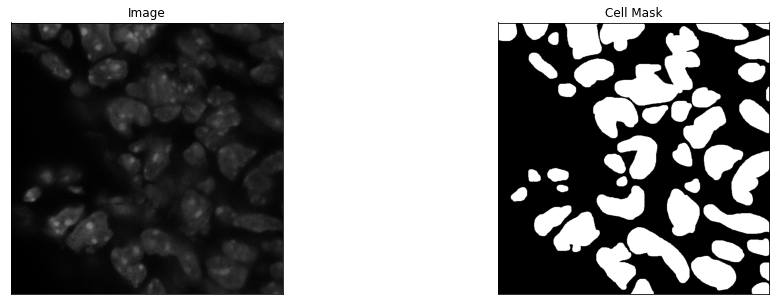

In [16]:
#@markdown Run this cell to defin the helper functions and visualize the images and masks. 
# helper function for data visualization

Object_to_segment='nuclei' #@param {type:"string"}

#@markdown For color intesity 255:white and 0:black
Color_intensity=255 #@param {type:"number"}


# Show image from dataset
dataset = Dataset(images_dir=images_dir, images_filelist=train_images_filelist, 
                  masks_dir=masks_dir, class_value_pairs={Object_to_segment:255})

image, mask = dataset[0] # get some sample
print(image.shape, mask.shape, image.max())

visualize(cmap="gray",
    image=image,
    cell_mask=mask[..., 0].squeeze()
    #background_mask=mask[..., 2].squeeze()
)

> ## **4.2. Defining augmentations and preprocessing functions**

In [17]:
#@markdown Run this cell to defin augmentation functions and visualize the images and masks. 
# helper function for data visualization

import warnings
warnings.filterwarnings('ignore')

def round_clip_0_1(x, **kwargs):
    return x.round().clip(0, 1)

# define heavy augmentations
def get_training_augmentation():
    train_transform = [

        A.HorizontalFlip(p=0.5),

        A.ShiftScaleRotate(scale_limit=0.5, rotate_limit=0, shift_limit=0.1, p=1, border_mode=0),

        A.PadIfNeeded(min_height=320, min_width=320, always_apply=True, border_mode=0),
        A.RandomCrop(height=320, width=320, always_apply=True),

        A.IAAAdditiveGaussianNoise(p=0.2),
        A.IAAPerspective(p=0.5),

        A.OneOf(
            [
                A.CLAHE(p=1),
                A.RandomBrightness(p=1),
                A.RandomGamma(p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.IAASharpen(p=1),
                A.Blur(blur_limit=3, p=1),
                A.MotionBlur(blur_limit=3, p=1),
            ],
            p=0.9,
        ),

        A.OneOf(
            [
                A.RandomContrast(p=1),
                A.HueSaturationValue(p=1),
            ],
            p=0.9,
        ),
        A.Lambda(mask=round_clip_0_1)
    ]
    return A.Compose(train_transform)

#Stretching

def get_validation_augmentation():
    """Add paddings to make image shape divisible by 32"""
    test_transform = [
        #A.PadIfNeeded(384, 480)
        #A.PadIfNeeded(320, 320),
        #A.RandomCrop(height=320, width=320, always_apply=True),
        A.Resize(320, 320, always_apply=True)
    ]
    return A.Compose(test_transform)

def get_preprocessing(preprocessing_fn):
    """Construct preprocessing transform
    
    Args:
        preprocessing_fn (callbale): data normalization function 
            (can be specific for each pretrained neural network)
    Return:
        transform: albumentations.Compose
    
    """
    
    _transform = [
        A.Lambda(image=preprocessing_fn),
    ]
    return A.Compose(_transform)



(320, 320, 3) (320, 320, 1) 109


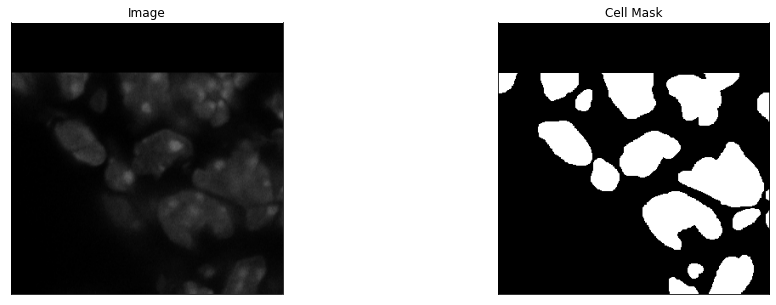

In [18]:
# Show augmented image from dataset
dataset = Dataset(images_dir=images_dir, images_filelist=train_images_filelist, masks_dir=masks_dir, class_value_pairs={'mitochondria':255}, augmentation=get_training_augmentation())

image, mask = dataset[1] # get some sample
print(image.shape, mask.shape, image.max())
visualize(cmap="gray",
    image=image, 
    cell_mask=mask[..., 0].squeeze()
    #background_mask=mask[..., 2].squeeze()
)

# **5. Define U-net parameters**
---



*   **ENCODER_WEIGHTS** – one of None (random initialization), imagenet (pre-training on ImageNet).
*   **BACKBONE** – name of classification model (without last dense layers) used as feature extractor to build segmentation model. You can try ```vgg16```, ```efficientnetb3```, ```efficientnetb7```,```inceptionv3```, ```resnet50```. 
*   **BATCH_SIZE** - The batch size defines the number of samples that will be propagated through the network.For instance, let's say you have 1050 training samples and you want to set up a batch_size equal to 100. The algorithm takes the first 100 samples (from 1st to 100th) from the training dataset and trains the network. Next, it takes the second 100 samples (from 101st to 200th) and trains the network again.
*   **LEARNING RATE (LR)** - The learning rate is a hyperparameter that controls how much to change the model in response to the estimated error each time the model weights are updated. Choosing the learning rate is challenging as a value too small may result in a long training process that could get stuck, whereas a value too large may result in learning a sub-optimal set of weights too fast or an unstable training process.
*   **EPOCHS** - The number of epochs is a hyperparameter of gradient descent that controls the number of complete passes through the training dataset.


In [23]:
#@markdown **Set parameters**
ENCODER_WEIGHTS = 'imagenet' #@param {type:"string"}
BACKBONE = 'inceptionv3'  #@param {type:"string"}
BATCH_SIZE = 2 #@param {type:"number"}
CLASS_NAME='nuclei' #@param {type:"string"}
PIXEL_LABEL=255 #@param {type:"string"}
class_value_pairs={CLASS_NAME:PIXEL_LABEL}
CLASSES = list(class_value_pairs.keys())
LR = 0.0001 #@param {type:"number"}
EPOCHS = 50 #@param {type:"number"}
preprocess_input = sm.get_preprocessing(BACKBONE)

# define network parameters
n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1)  # case for binary and multiclass segmentation
activation = 'sigmoid' if n_classes == 1 else 'softmax'

# **6. Create model**
---

In [24]:
model = sm.Unet(BACKBONE, classes=n_classes, encoder_weights=ENCODER_WEIGHTS, activation=activation)

Defining the optimizer

In [25]:
optim = tf.keras.optimizers.Adam(LR)

Segmentation models losses can be combined together by '+' and scaled by integer or float factor

In [26]:
dice_loss = sm.losses.DiceLoss()
focal_loss = sm.losses.BinaryFocalLoss() if n_classes == 1 else sm.losses.CategoricalFocalLoss()
total_loss = dice_loss + (1 * focal_loss)


Compile keras model with defined optimozer, loss and metrics

In [27]:
metrics = [sm.metrics.IOUScore(threshold=0.5), sm.metrics.FScore(threshold=0.5)]
model.compile(optim, total_loss, metrics)

> ## **6.1. Setup the network for training and validation datasets**

In [28]:
# Dataset for train images
train_dataset = Dataset(
    images_dir=images_dir,
    images_filelist=train_images_filelist,
    masks_dir=masks_dir,
    class_value_pairs={CLASS_NAME:PIXEL_LABEL},
    augmentation=get_training_augmentation(),
    preprocessing=get_preprocessing(preprocess_input)
)

# Dataset for validation images
valid_dataset = Dataset(
    images_dir=images_dir,
    images_filelist=val_images_filelist,
    masks_dir=masks_dir,
    class_value_pairs={CLASS_NAME:PIXEL_LABEL},
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input)
)

train_dataloader = Dataloader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_dataloader = Dataloader(valid_dataset, batch_size=1, shuffle=False)

# check shapes for errors
assert train_dataloader[0][0].shape == (BATCH_SIZE, 320, 320, 3)
assert train_dataloader[0][1].shape == (BATCH_SIZE, 320, 320, n_classes)


Next, we will define the name of the CNN and directory where we want to save it. 

In [29]:

models_dir = "C:/Users/utraf/Documents/Nathaly/Cerebellum Team/Malala/Nuclei" #@param {type:"string"}
#@markdown  define callbacks for learning rate scheduling and best checkpoints saving
name_CNN =  '/trial_vgg16_best_model_3march2022.h5' #@param {type:"string"}
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(models_dir+name_CNN, save_weights_only=True, save_best_only=True, mode='min'),
    tf.keras.callbacks.ReduceLROnPlateau(),
]

> ## **6.2. Training Model**

In [30]:
history = model.fit(
    train_dataloader,
    steps_per_epoch=len(train_dataloader),
    epochs=EPOCHS,
    callbacks=callbacks,
    validation_data=valid_dataloader,
    validation_steps=len(valid_dataloader)
)

Epoch 1/50
9/9 [==============================] - 21s 509ms/step - loss: 0.5899 - iou_score: 0.4618 - f1-score: 0.6287 - val_loss: 0.6783 - val_iou_score: 0.4118 - val_f1-score: 0.5830 - lr: 1.0000e-04
Epoch 2/50
9/9 [==============================] - 2s 174ms/step - loss: 0.4954 - iou_score: 0.5617 - f1-score: 0.7182 - val_loss: 0.6052 - val_iou_score: 0.4678 - val_f1-score: 0.6370 - lr: 1.0000e-04
Epoch 3/50
9/9 [==============================] - 2s 177ms/step - loss: 0.4405 - iou_score: 0.6373 - f1-score: 0.7763 - val_loss: 0.5533 - val_iou_score: 0.5504 - val_f1-score: 0.7097 - lr: 1.0000e-04
Epoch 4/50
9/9 [==============================] - 2s 173ms/step - loss: 0.4063 - iou_score: 0.6713 - f1-score: 0.7989 - val_loss: 0.5096 - val_iou_score: 0.5894 - val_f1-score: 0.7415 - lr: 1.0000e-04
Epoch 5/50
9/9 [==============================] - 2s 172ms/step - loss: 0.4471 - iou_score: 0.6509 - f1-score: 0.7849 - val_loss: 0.4852 - val_iou_score: 0.6117 - val_f1-score: 0.7589 - lr: 1.000

Epoch 42/50
9/9 [==============================] - 1s 130ms/step - loss: 0.2225 - iou_score: 0.7989 - f1-score: 0.8879 - val_loss: 0.2536 - val_iou_score: 0.7880 - val_f1-score: 0.8813 - lr: 1.0000e-05
Epoch 43/50
9/9 [==============================] - 1s 131ms/step - loss: 0.2193 - iou_score: 0.8097 - f1-score: 0.8947 - val_loss: 0.2532 - val_iou_score: 0.7881 - val_f1-score: 0.8814 - lr: 1.0000e-05
Epoch 44/50
9/9 [==============================] - 1s 133ms/step - loss: 0.2626 - iou_score: 0.7727 - f1-score: 0.8692 - val_loss: 0.2570 - val_iou_score: 0.7859 - val_f1-score: 0.8800 - lr: 1.0000e-05
Epoch 45/50
9/9 [==============================] - 1s 139ms/step - loss: 0.2086 - iou_score: 0.8149 - f1-score: 0.8974 - val_loss: 0.2565 - val_iou_score: 0.7865 - val_f1-score: 0.8803 - lr: 1.0000e-05
Epoch 46/50
9/9 [==============================] - 1s 127ms/step - loss: 0.2242 - iou_score: 0.8089 - f1-score: 0.8938 - val_loss: 0.2546 - val_iou_score: 0.7874 - val_f1-score: 0.8809 - lr: 1

# **7. Plotting scoring values**
---

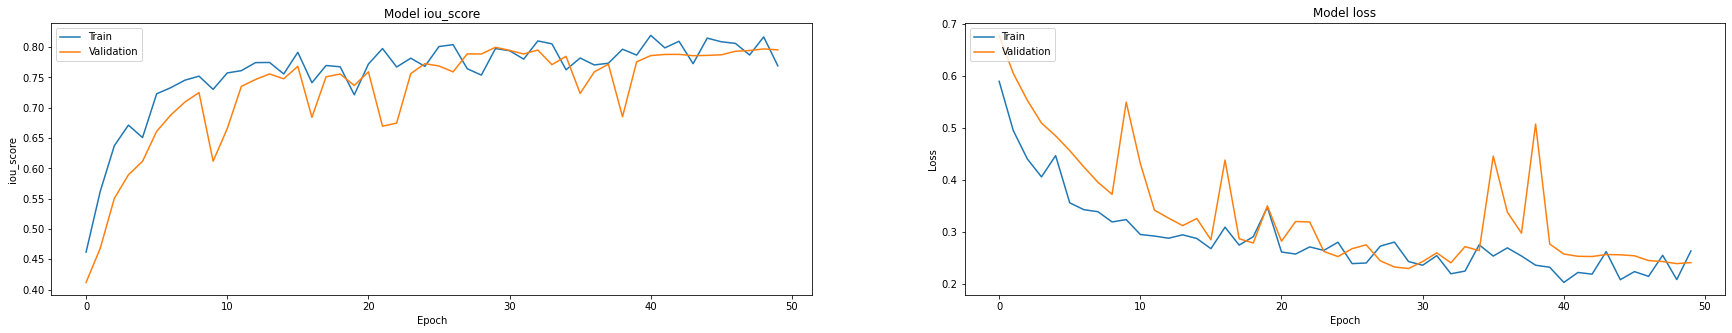

In [31]:
#@markdown **Plot 1: training and validation iou_score values & Plot 2: Plot training and validation loss values**

plt.figure(figsize=(30, 5))
plt.subplot(121)
plt.plot(history.history['iou_score'])
plt.plot(history.history['val_iou_score'])
plt.title('Model iou_score')
plt.ylabel('iou_score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
 
plt.subplot(122)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# **8. Model Evaluation**
---

> ### **8.1. Loading model with best weights**

In [33]:
test_dataset = Dataset(
    images_dir=images_dir,
    images_filelist=test_images_filelist,
    masks_dir=masks_dir,
    class_value_pairs={CLASS_NAME:PIXEL_LABEL},
    augmentation=get_validation_augmentation(),
    preprocessing=get_preprocessing(preprocess_input)
)


#@markdown
test_dataloader = Dataloader(test_dataset, batch_size=1, shuffle=False)

best_weights= 'C:/Users/utraf/Documents/Nathaly/Cerebellum Team/Malala/Nuclei/trial_vgg16_best_model_3march2022.h5'#@param {type:"string"}
model.load_weights(best_weights)
scores = model.evaluate(test_dataloader)

print("Loss: {:.5}".format(scores[0]))
for metric, value in zip(metrics, scores[1:]):
    print("mean {}: {:.5}".format(metric.__name__, value))

7/7 [==============================] - 0s 28ms/step - loss: 0.2493 - iou_score: 0.7858 - f1-score: 0.8800
Loss: 0.24934
mean iou_score: 0.78583
mean f1-score: 0.88


> ### **8.2.Visualizing model evaluation with testing images**

(1, 320, 320, 3) (1, 320, 320, 1)


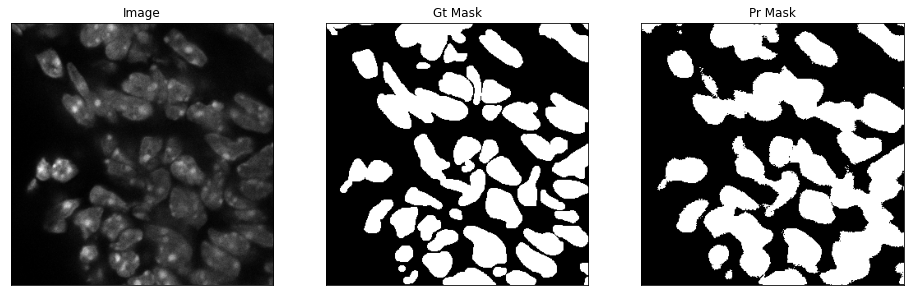

(1, 320, 320, 3) (1, 320, 320, 1)


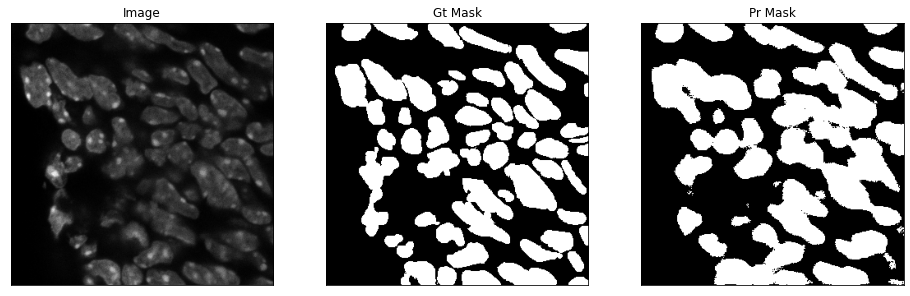

(1, 320, 320, 3) (1, 320, 320, 1)


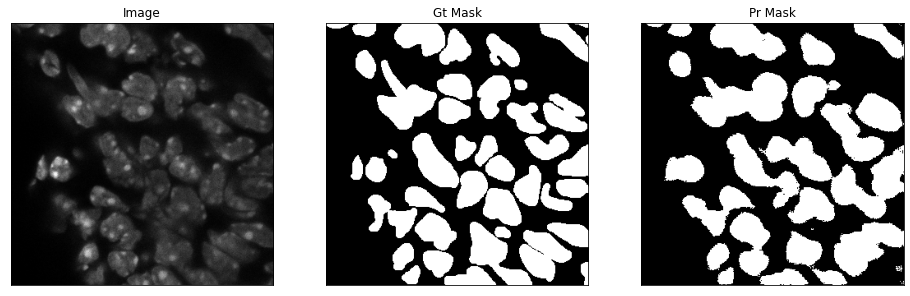

(1, 320, 320, 3) (1, 320, 320, 1)


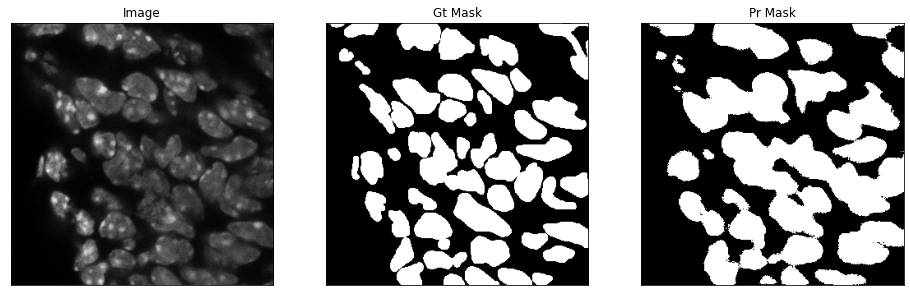

In [34]:
ids = np.random.choice(np.arange(len(test_dataset)), size=4)

ids = np.arange(4)

for i in ids:
  image, gt_mask = test_dataset[i]
  image = np.expand_dims(image, axis=0)
  pr_mask = model.predict(image).round()
  print(image.shape, pr_mask.shape)
  visualize(cmap="gray",
            image=image[0][:,:,0],
            gt_mask=gt_mask[..., 0].squeeze(),
            pr_mask=pr_mask[..., 0].squeeze()
            #background_mask=mask[..., 2].squeeze()
            )

# **9. Inference**
---



> ### **9.1. Loading images and masks**



>  ### **9.2. Loading model of CNN**

In [48]:
#Break the large image (volume) into patches of same size as the training images (patches)
from skimage import io
from patchify import patchify, unpatchify

best_weights= 'C:/Users/utraf/Documents/Nathaly/Cerebellum Team/Malala/Nuclei/trial_vgg16_best_model_3march2022.h5'#@param {type:"string"}
model.load_weights(best_weights)

large_image = io.imread('C:/Users/utraf/Documents/Nathaly/Cerebellum Team/Malala/Test/complete_Lob8.tif')

print(large_image.shape)
large_image=large_image[:,0:1400,0:1400]
patches = patchify(large_image, (1, 300, 300), step=(1, 50, 50))



(35, 1437, 1437)


In [49]:
#patches = patchify(large_image, (1, 300, 300), step=(1, 100, 100))  #Step=256 for 256 patches means no overlap
print(large_image.shape)
print(patches.shape)
type(patches)
reconstructed_image = unpatchify(patches, large_image.shape)

(35, 1400, 1400)
(35, 23, 23, 1, 300, 300)


In [50]:
# Define augmentation (remember to use validation_augmentation)
augmentation=get_validation_augmentation()

# Define preprocessing
preprocess_input = sm.get_preprocessing(BACKBONE)
preprocessing=get_preprocessing(preprocess_input)

predicted_patches = []
for i in range(patches.shape[0]):
  for j in range(patches.shape[1]):
    for k in range(patches.shape[2]):
      #print(i,j,k)
      single_patch = patches[i,j,k, :,:,:]
      single_patch_3ch = np.stack((single_patch,)*3, axis=-1)

      image = single_patch_3ch[0]
      #print(image.shape)

      # Apply augmentation only if you cannot get a required dimensions of the tile
      sample = augmentation(image=image)
      image = sample['image']

      # Apply preprocessing
      sample = preprocessing(image=image)
      image = sample['image']

      #single_patch_3ch_input = preprocess_input(np.expand_dims(single_patch_3ch, axis=0))
      
      image = np.expand_dims(image, axis=0)
      #image = np.stack((image,)*3, axis=-1)
      #print(image.shape)
      single_patch_prediction = model.predict(image).round()
      #print("***", single_patch_prediction.shape)
      img = single_patch_prediction[0][:,:,0]
      #print(img.shape)
      img = cv2.resize(img, single_patch_3ch[0].shape[:2])
      #print(img.shape)
      single_patch_prediction = np.expand_dims(np.expand_dims(img, axis=2), axis=0)
      #break
      predicted_patches.append(single_patch_prediction)
    #break
  #break

In [51]:
#Convert list to numpy array
predicted_patches = np.array(predicted_patches)
print(predicted_patches.shape)

(18515, 1, 300, 300, 1)


In [52]:
#Reshape to the shape we had after patchifying
predicted_patches_reshaped = np.reshape(predicted_patches, 
                                        (patches.shape[0], patches.shape[1], patches.shape[2],
                                         patches.shape[3], patches.shape[4], patches.shape[5]) )
print(predicted_patches_reshaped.shape)


(35, 23, 23, 1, 300, 300)


In [53]:
#Repach individual patches into the orginal volume shape
reconstructed_image = unpatchify(predicted_patches_reshaped, large_image.shape)
print(reconstructed_image.shape)

(35, 1400, 1400)


In [54]:
print(reconstructed_image.dtype)

float32


In [55]:
#Convert to uint8 so we can open image in most image viewing software packages
reconstructed_image=reconstructed_image.astype(np.uint8)
print(reconstructed_image.dtype)

uint8


In [56]:
#Now save it as segmented volume.
from tifffile import imsave
imsave('C:/Users/utraf/Documents/Nathaly/Cerebellum Team/Malala/Test/Pred_seg_nuclei_Lob9_analysis.tif', reconstructed_image)

# **References**
*   https://stats.stackexchange.com/questions/153531/what-is-batch-size-in-neural-network
*   https://machinelearningmastery.com/understand-the-dynamics-of-learning-rate-on-deep-learning-neural-networks/
